In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino Sans"

import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 階層ベイズモデル

### データ準備

In [2]:
df = sns.load_dataset("iris")
display(df.head())
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [3]:
df0 = df[df["species"] == "setosa"]
df1 = df[df["species"] == "versicolor"]
df2 = df[df["species"] == "virginica"]

In [4]:
import random
random.seed(42)

indexes = range(len(df1))
sample_indexes = random.sample(indexes, 3)

df0_sel = df0.iloc[sample_indexes]
df1_sel = df1.iloc[sample_indexes]
df2_sel = df2.iloc[sample_indexes]

df_sel = pd.concat([df0_sel, df1_sel, df2_sel], axis=0).reset_index(drop=True)
display(df_sel)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.0,3.5,1.3,0.3,setosa
1,5.0,3.4,1.5,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,5.5,2.6,4.4,1.2,versicolor
4,4.9,2.4,3.3,1.0,versicolor
5,6.4,3.2,4.5,1.5,versicolor
6,6.7,3.1,5.6,2.4,virginica
7,7.3,2.9,6.3,1.8,virginica
8,5.8,2.7,5.1,1.9,virginica


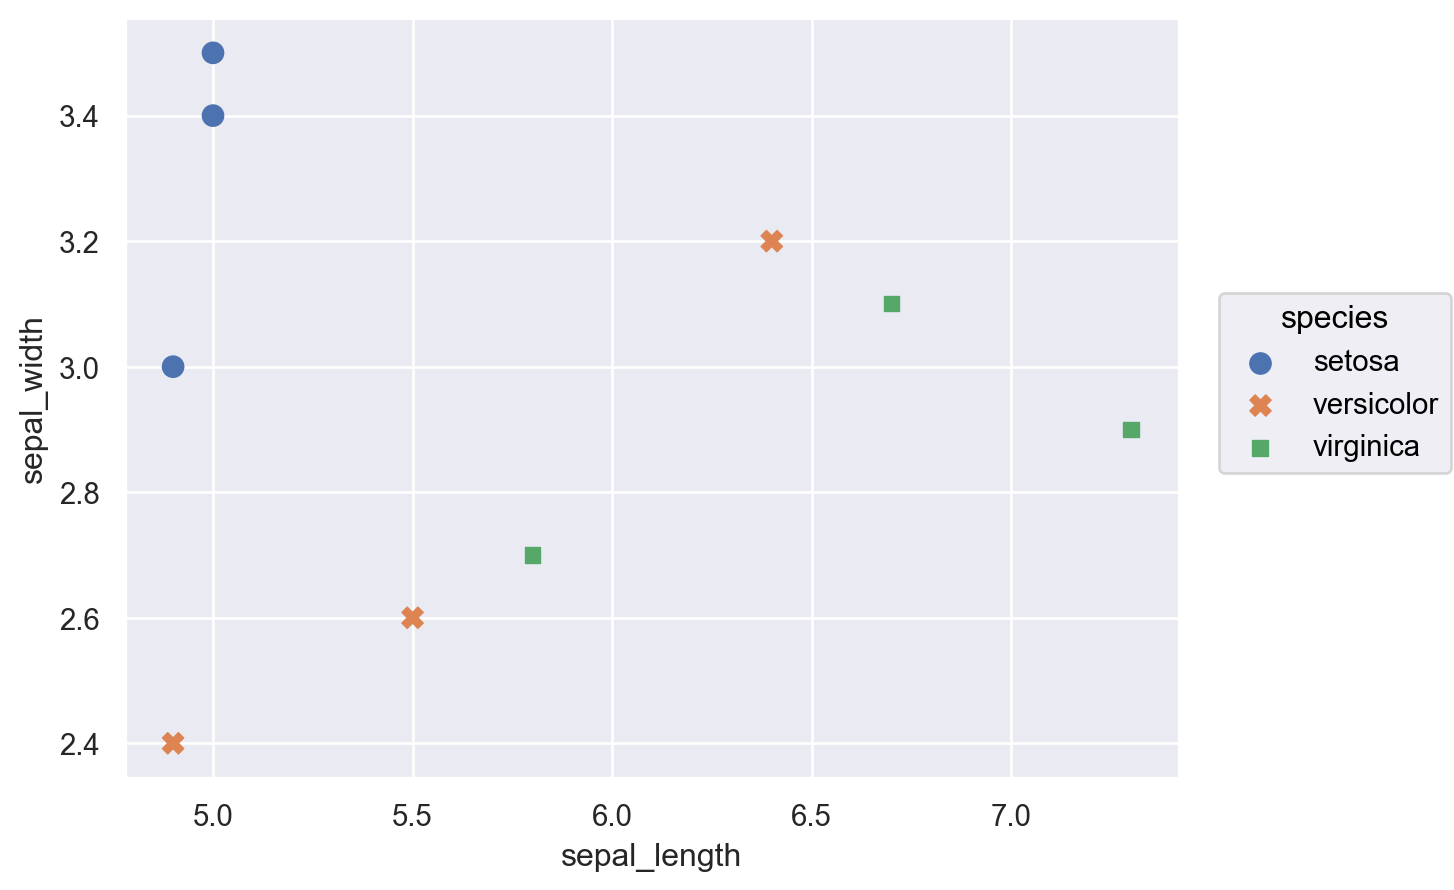

In [5]:
(
    so.Plot(df_sel, x="sepal_length", y="sepal_width", color="species", marker="species")
    .add(so.Dot(pointsize=8))
)

In [6]:
X = df_sel["sepal_length"].to_numpy()
Y = df_sel["sepal_width"].to_numpy()

species = df_sel["species"]
cl = pd.Categorical(species).codes

print(X)
print(Y)
print(species.to_numpy())
print(cl)

[5.  5.  4.9 5.5 4.9 6.4 6.7 7.3 5.8]
[3.5 3.4 3.  2.6 2.4 3.2 3.1 2.9 2.7]
['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


### 確率モデル定義

In [7]:
np.unique(cl).size

3

In [8]:
with pm.Model() as model1:
    X_data = pm.ConstantData("X_data", X)
    Y_data = pm.ConstantData("Y_data", Y)

    cl_data = pm.ConstantData("cl_data", cl)

    a_mu = pm.Normal("a_mu", mu=0.0, sigma=10.0)
    a_sigma = pm.HalfNormal("a_sigma", sigma=10.0)
    alpha = pm.Normal("alpha", mu=a_mu, sigma=a_sigma, shape=np.unique(cl).size)

    b_mu = pm.Normal("b_mu", mu=0.0, sigma=10.0)
    b_sigma = pm.HalfNormal("b_sigma", sigma=10.0)
    beta = pm.Normal("beta", mu=b_mu, sigma=b_sigma, shape=np.unique(cl).size)

    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    mu = pm.Deterministic("mu", X_data * alpha[cl_data] + beta[cl_data])

    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

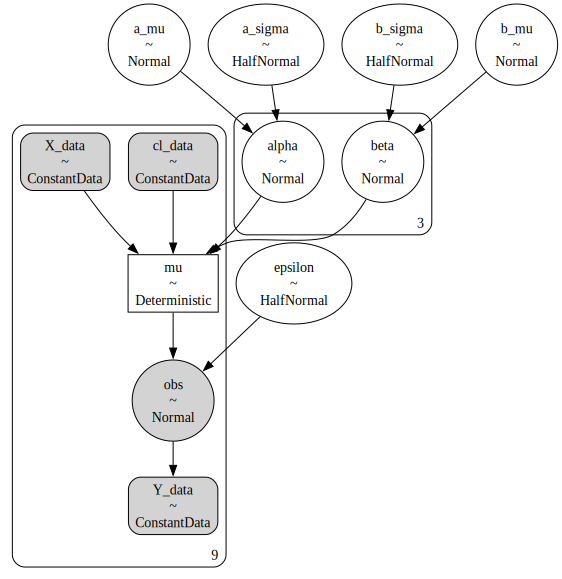

In [9]:
g = pm.model_to_graphviz(model1)
display(g)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a_mu, a_sigma, alpha, b_mu, b_sigma, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


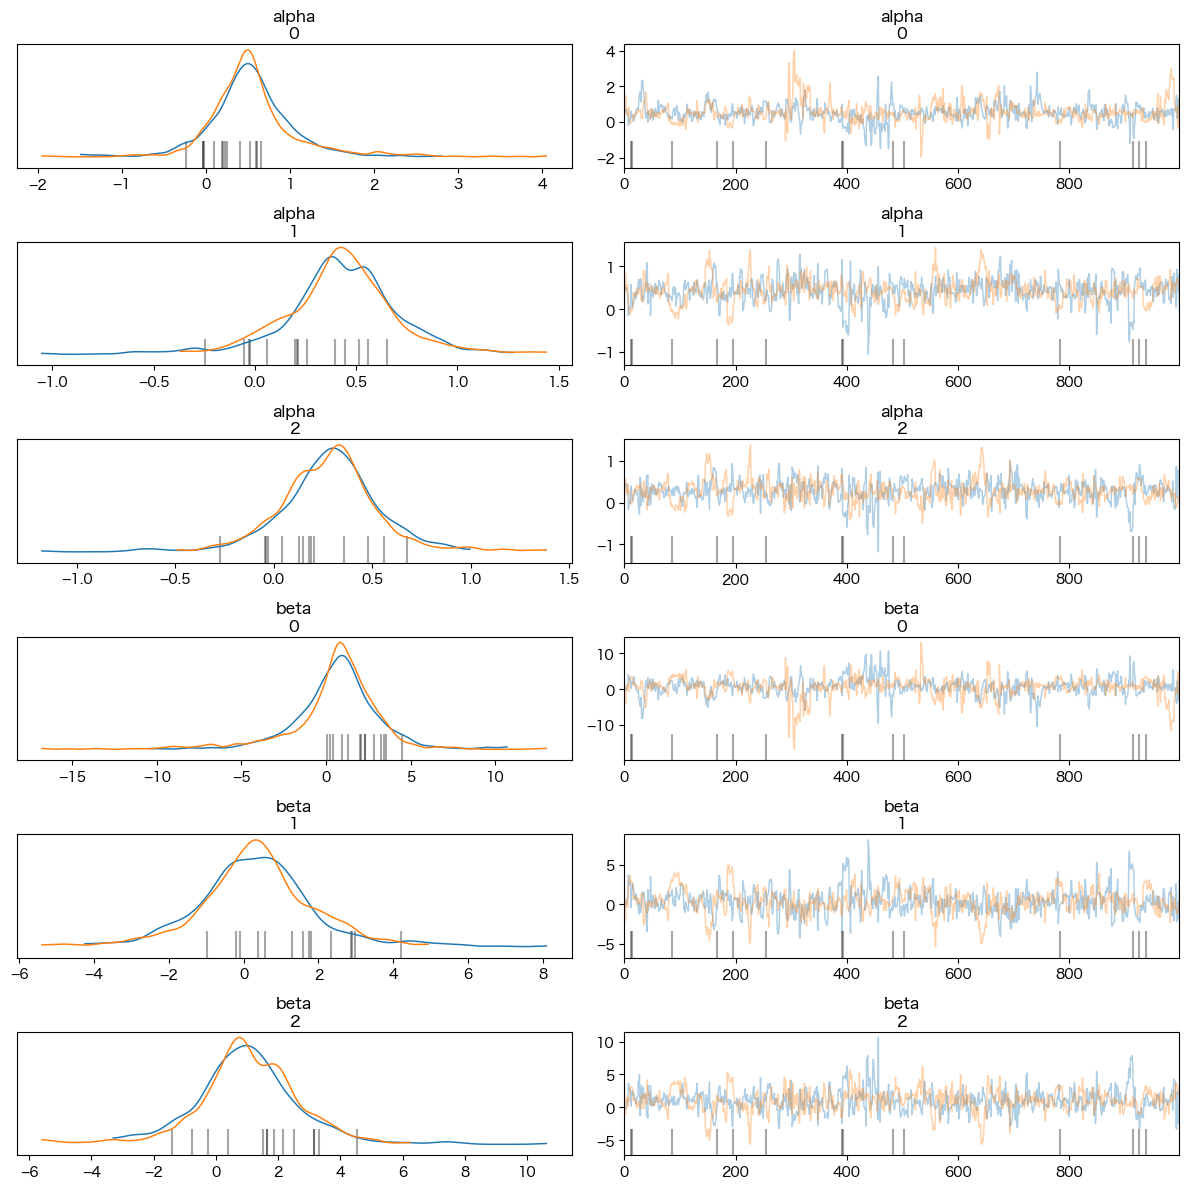

In [10]:
with model1:
    idata1 = pm.sample(random_seed=42, chains=2, target_accept=0.998)

az.plot_trace(idata1, compact=False, var_names=["alpha", "beta"])
plt.tight_layout()

In [11]:
summary1 = az.summary(idata1, var_names=["alpha", "beta"])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.541,0.526,-0.429,1.523,0.039,0.030,219.0,198.0,1.0
alpha[1],0.429,0.274,-0.107,0.953,0.017,0.012,280.0,319.0,1.0
alpha[2],0.283,0.252,-0.201,0.761,0.014,0.010,344.0,398.0,1.0
beta[0],0.610,2.615,-4.504,5.194,0.195,0.141,218.0,192.0,1.0
beta[1],0.337,1.546,-2.778,3.235,0.095,0.067,277.0,329.0,1.0
beta[2],1.032,1.663,-2.055,4.314,0.093,0.066,340.0,388.0,1.0


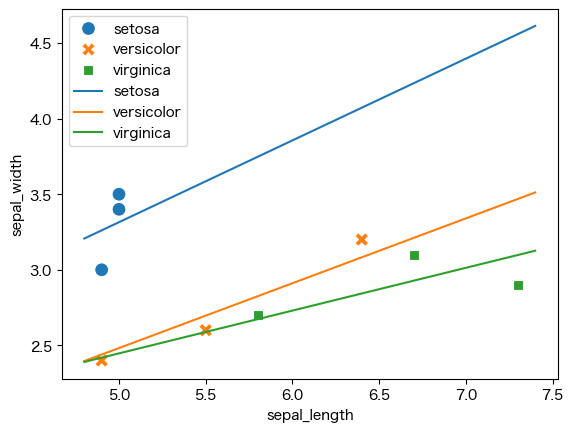

In [12]:
means = summary1["mean"]
alpha0 = means["alpha[0]"]
alpha1 = means["alpha[1]"]
alpha2 = means["alpha[2]"]
beta0 = means["beta[0]"]
beta1 = means["beta[1]"]
beta2 = means["beta[2]"]

x_range = np.array([X.min() - 0.1, X.max() + 0.1])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

sns.scatterplot(
    x="sepal_length", y="sepal_width", hue="species", style="species", data=df_sel, s=100
)
plt.plot(x_range, y0_range, label="setosa")
plt.plot(x_range, y1_range, label="versicolor")
plt.plot(x_range, y2_range, label="virginica")
plt.legend();

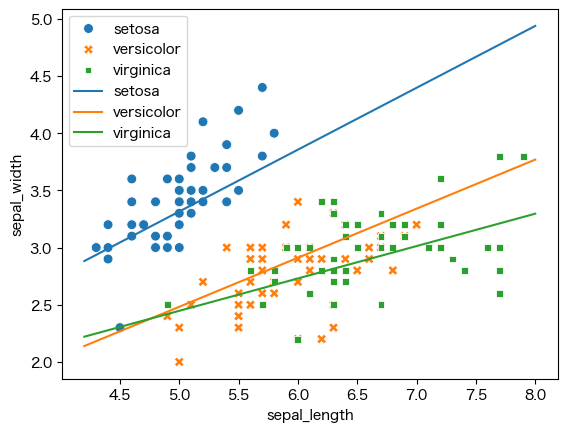

In [13]:
x_range = np.array([
    df["sepal_length"].min() - 0.1,
    df["sepal_length"].max() + 0.1
])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

sns.scatterplot(
    x="sepal_length", y="sepal_width", hue="species", style="species", data=df, s=50
)
plt.plot(x_range, y0_range, label="setosa")
plt.plot(x_range, y1_range, label="versicolor")
plt.plot(x_range, y2_range, label="virginica")
plt.legend();

## 潜在変数モデル

In [14]:
df2 = df[df["species"] != "setosa"]
df2 = df2.reset_index(drop=True)

X = df2["petal_width"].to_numpy()

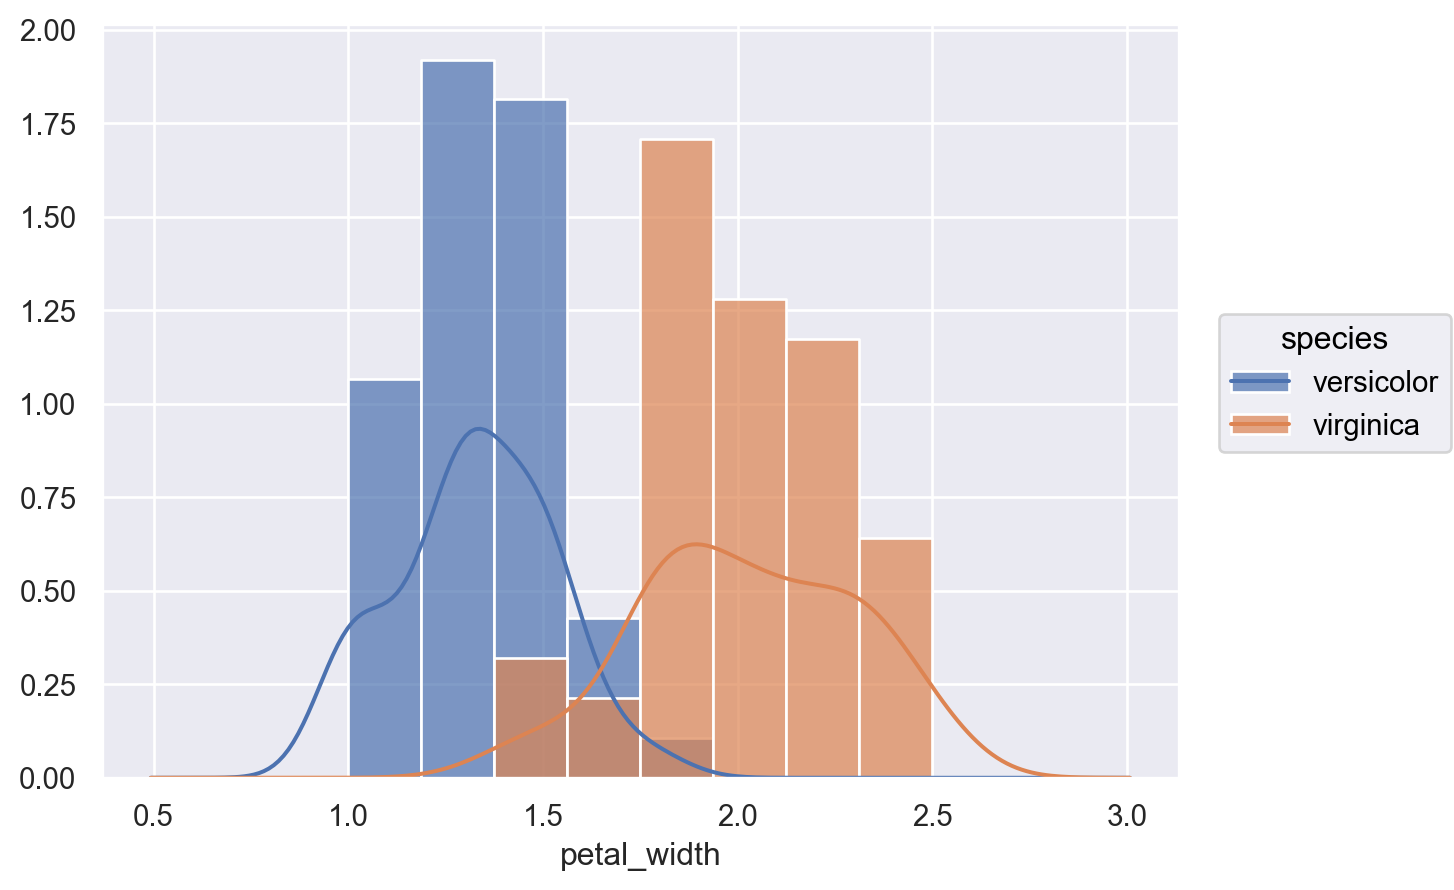

In [15]:
(
    so.Plot(data=df2, x="petal_width", color="species")
    .add(so.Bars(), so.Hist("density"))
    .add(so.Line(), so.KDE())
)

$$
\begin{align}
f(x) &= \frac{1}{\sqrt{2\pi}\sigma} \exp{\left(- \frac{(x - \mu)^2}{2\sigma^2} \right)} \\
\tau &= \frac{1}{\sigma^2} \\
f(x) &= \frac{\sqrt{\tau}}{\sqrt{2\pi}} \exp{\left(- \frac{\tau(x - \mu)^2}{2} \right)}
\end{align}
$$

## モデル定義

In [16]:
n_components = 2
N = X.shape

with pm.Model() as model2:
    X_data = pm.ConstantData("X_data", X)

    p = pm.Uniform("p", lower=0.0, upper=1.0)
    s = pm.Bernoulli("s", p=p, shape=N)

    mus = pm.Normal("mus", mu=0.0, sigma=10.0, shape=n_components)
    taus = pm.HalfNormal("taus", sigma=10.0, shape=n_components)

    sigmas = pm.Deterministic("sigmas", 1 / pm.math.sqrt(taus))

    mu = pm.Deterministic("mu", mus[s])
    tau = pm.Deterministic("tau", taus[s])

    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X_data)

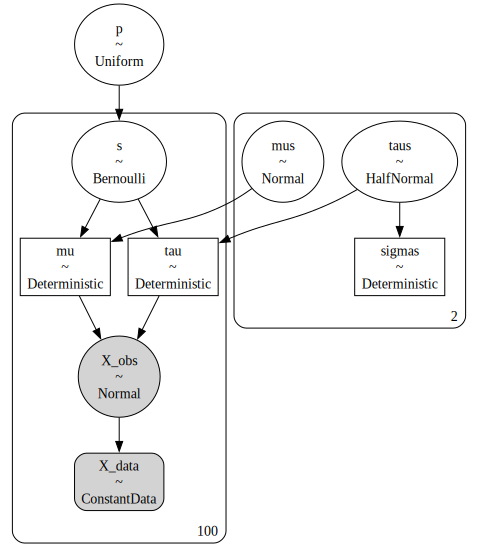

In [17]:
g = pm.model_to_graphviz(model2)
display(g)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


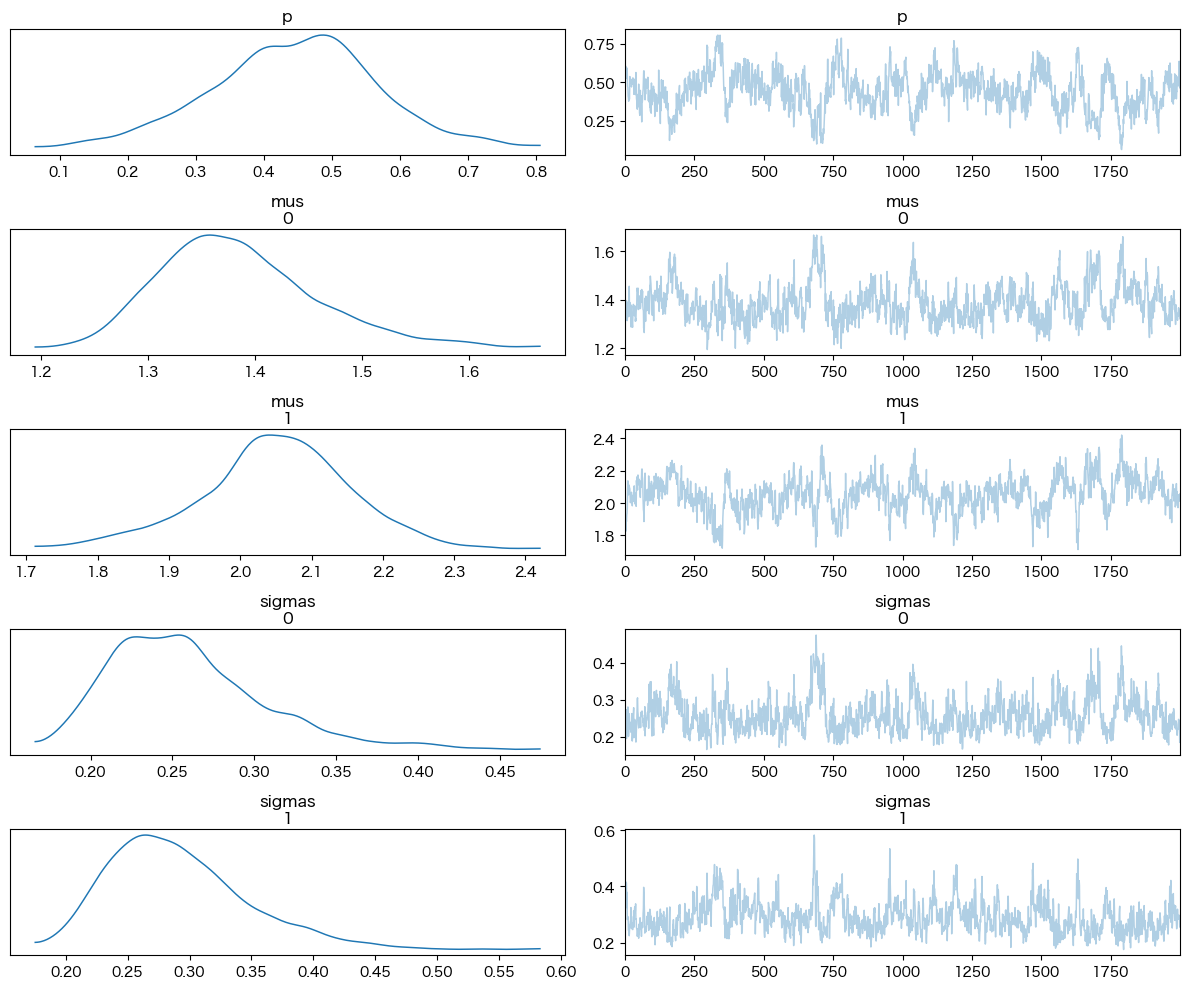

In [18]:
with model2:
    idata2 = pm.sample(chains=1, draws=2000, target_accept=0.99, random_seed=42)

ax = az.plot_trace(idata2, var_names=["p", "mus", "sigmas"], compact=False)
plt.tight_layout();

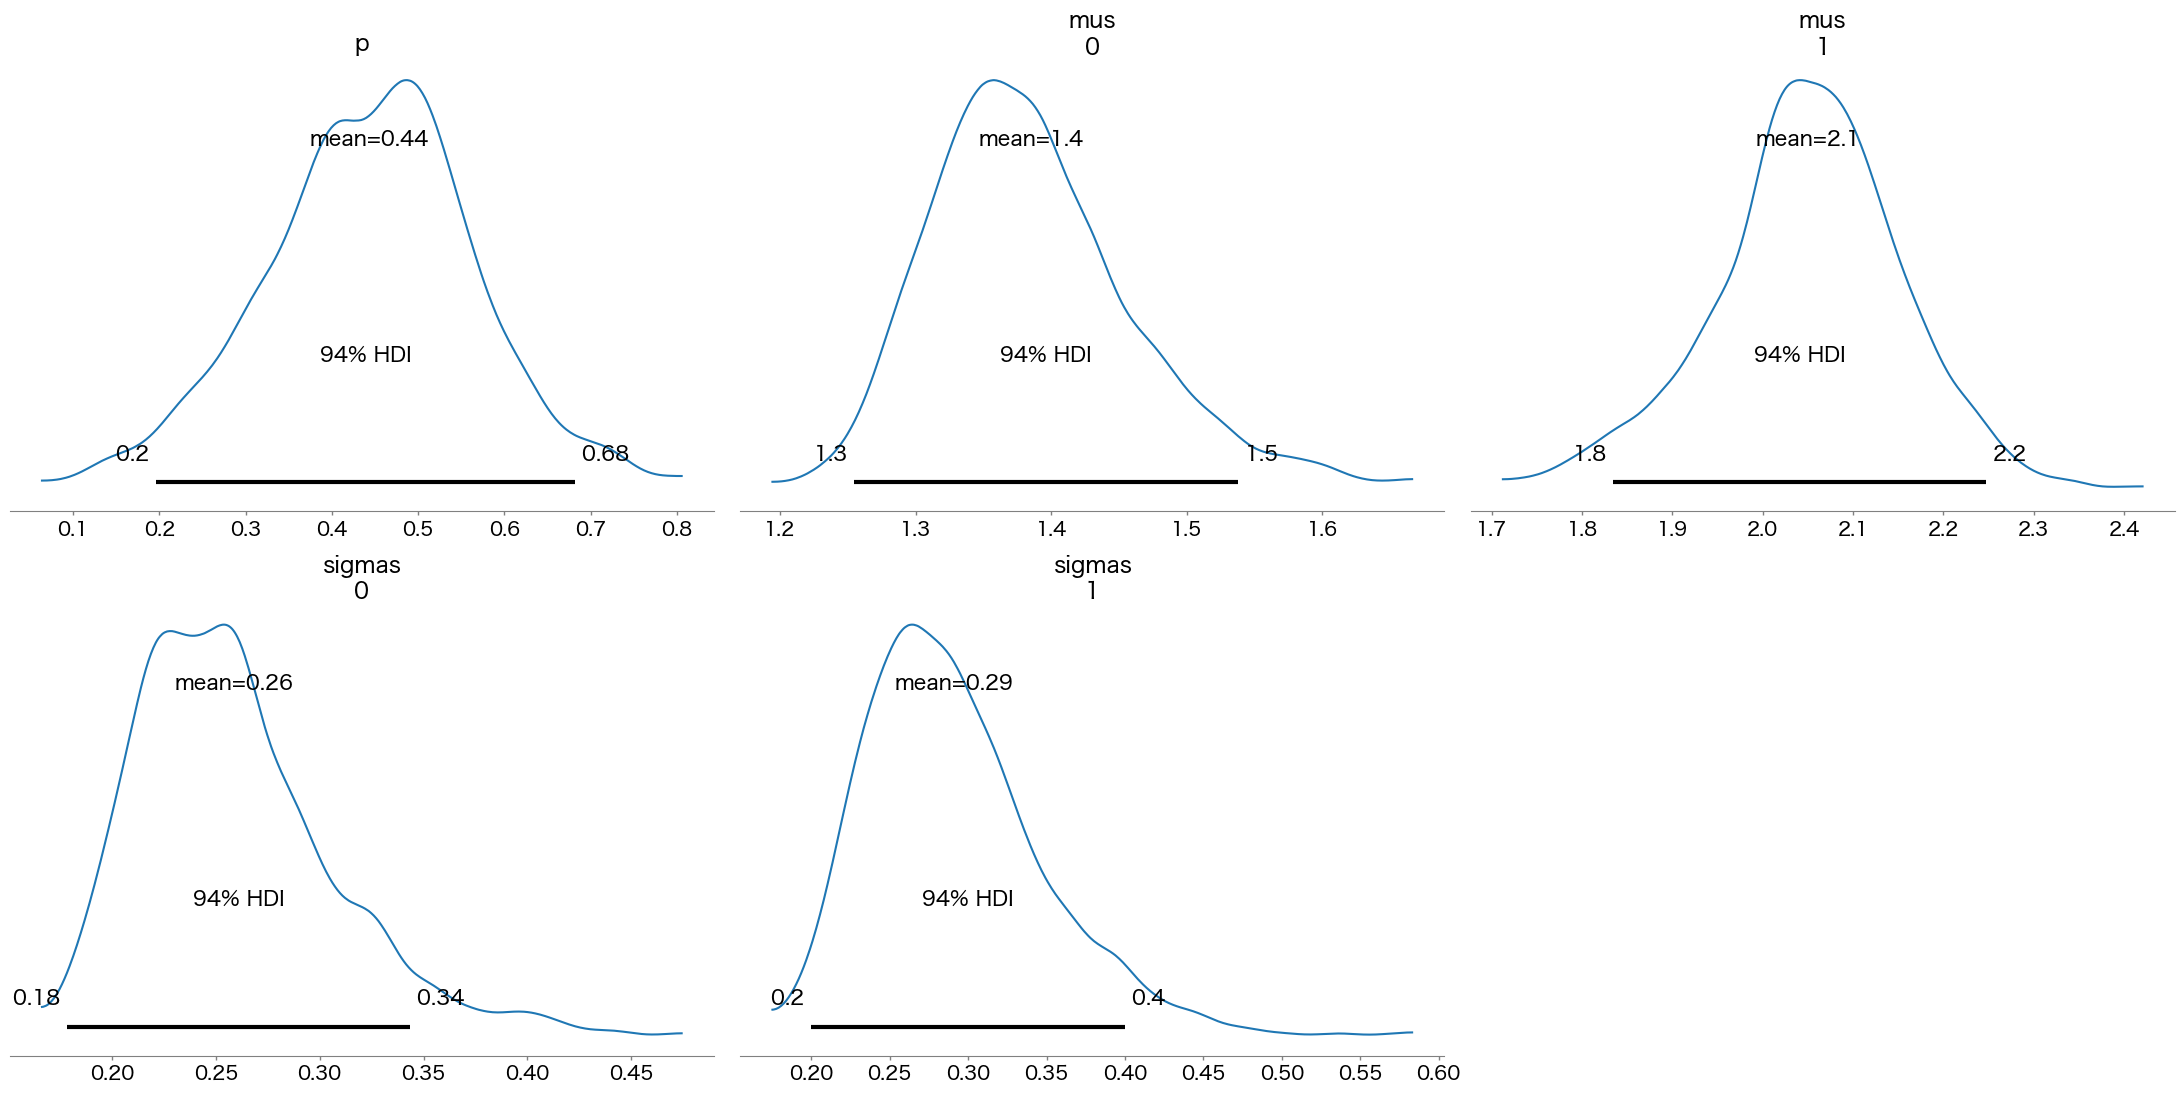

In [19]:
az.plot_posterior(idata2, var_names=["p", "mus", "sigmas"])
plt.tight_layout()

In [20]:
summary2 = az.summary(idata2,  var_names=["p", "mus", "sigmas"])
display(summary2)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.443,0.125,0.197,0.682,0.015,0.011,66.0,148.0,NaN
mus[0],1.386,0.077,1.255,1.538,0.009,0.006,82.0,113.0,NaN
mus[1],2.050,0.107,1.834,2.247,0.013,0.009,69.0,135.0,NaN
sigmas[0],0.259,0.047,0.178,0.343,0.005,0.004,106.0,139.0,NaN
sigmas[1],0.291,0.056,0.200,0.400,0.006,0.004,88.0,294.0,NaN


## ヒストグラムと正規分布の重ね描き

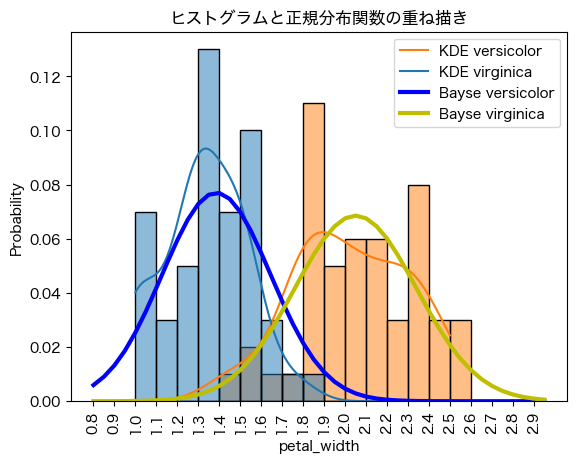

In [21]:
def norm(x, mu, sigma):
    return np.exp(-((x - mu) / sigma)**2 / 2) / (np.sqrt(2 * np.pi) * sigma)

mean = summary2["mean"]
mean_mu0 = mean["mus[0]"]
mean_mu1 = mean["mus[1]"]

mean_sigma0 = mean["sigmas[0]"]
mean_sigma1 = mean["sigmas[1]"]

x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

bins = np.arange(0.8, 3.0, delta)
fig, ax = plt.subplots()
sns.histplot(data=df2, bins=bins, x="petal_width", hue="species", kde=True, ax=ax, stat="probability")
ax.get_lines()[0].set_label("KDE versicolor")
ax.get_lines()[1].set_label("KDE virginica")
ax.plot(x, y0, c="b", lw=3, label="Bayse versicolor")
ax.plot(x, y1, c="y", lw=3, label="Bayse virginica")
ax.set_xticks(bins)

ax.xaxis.set_tick_params(rotation=90)
ax.set_title("ヒストグラムと正規分布関数の重ね描き")
plt.legend();

### 潜在変数の確率分布

In [22]:
value_list = [1.0, 1.5, 1.7, 2.0, 2.5]
df_heads = pd.DataFrame()
for value in value_list:
    w = df2[df2["petal_width"] == value]
    df_heads = pd.concat([df_heads, w.head(1)], axis=0)

display(df_heads)

,sepal_length,sepal_width,petal_length,petal_width,species
7,4.9,2.4,3.3,1.0,versicolor
1,6.4,3.2,4.5,1.5,versicolor
27,6.7,3.0,5.0,1.7,versicolor
60,6.5,3.2,5.1,2.0,virginica
50,6.3,3.3,6.0,2.5,virginica


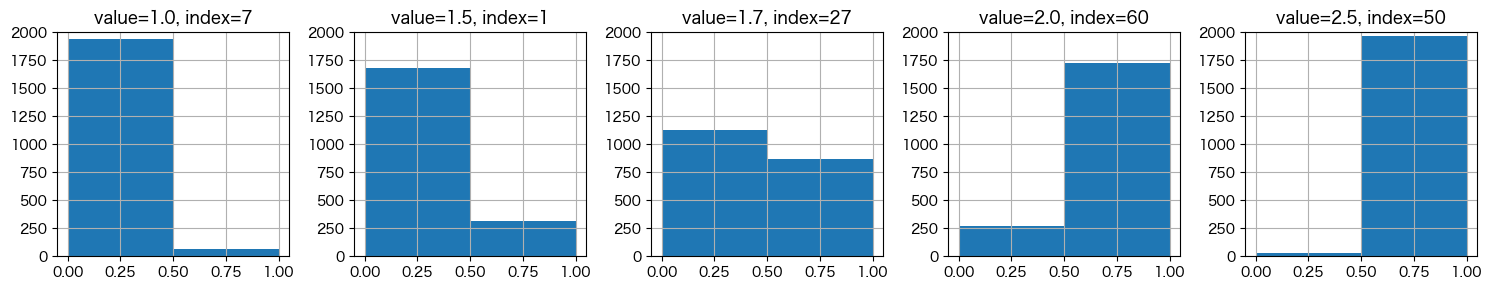

In [23]:
indexes, n_indexes = df_heads.index, len(df_heads)
sval = idata2["posterior"]["s"][:, :, indexes].to_numpy().reshape(-1, n_indexes).T

plt.rcParams["figure.figsize"] = (15, 3)
vlist = df_heads["petal_width"]
fig, axes = plt.subplots(1, n_indexes)
for ax, item, value, index in zip(axes, sval, vlist, indexes):
    f = pd.DataFrame(item)
    f.hist(ax=ax, bins=2)
    ax.set_ylim(0, 2000)
    ax.set_title(f"value={value}, index={index}")
plt.tight_layout();

### ラベルスイッチが起きない確率モデル

In [24]:
with pm.Model() as model3:
    X_data = pm.ConstantData("X_data", X)
    
    p = pm.Uniform("p", lower=0.0, upper=1.0)
    s = pm.Bernoulli("s", p=p, shape=N)

    mu0 = pm.HalfNormal("mu0", sigma=10.0)
    delta0 = pm.HalfNormal("delta0", sigma=10.0)
    mu1 = pm.Deterministic("mu1", mu0 + delta0)
    mus = pm.Deterministic("mus", pm.math.stack([mu0, mu1]))

    taus = pm.HalfNormal("taus", sigma=10.0, shape=n_components)
    sigmas = pm.Deterministic("sigmas", 1 / pm.math.sqrt(taus))

    mu = pm.Deterministic("mu", mus[s])
    tau = pm.Deterministic("tau", taus[s])

    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X_data)

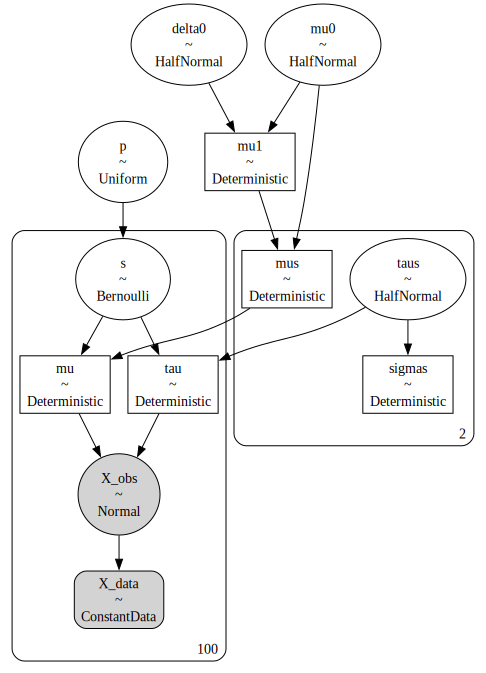

In [25]:
g = pm.model_to_graphviz(model3)
display(g)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p, mu0, delta0, taus]
>BinaryGibbsMetropolis: [s]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


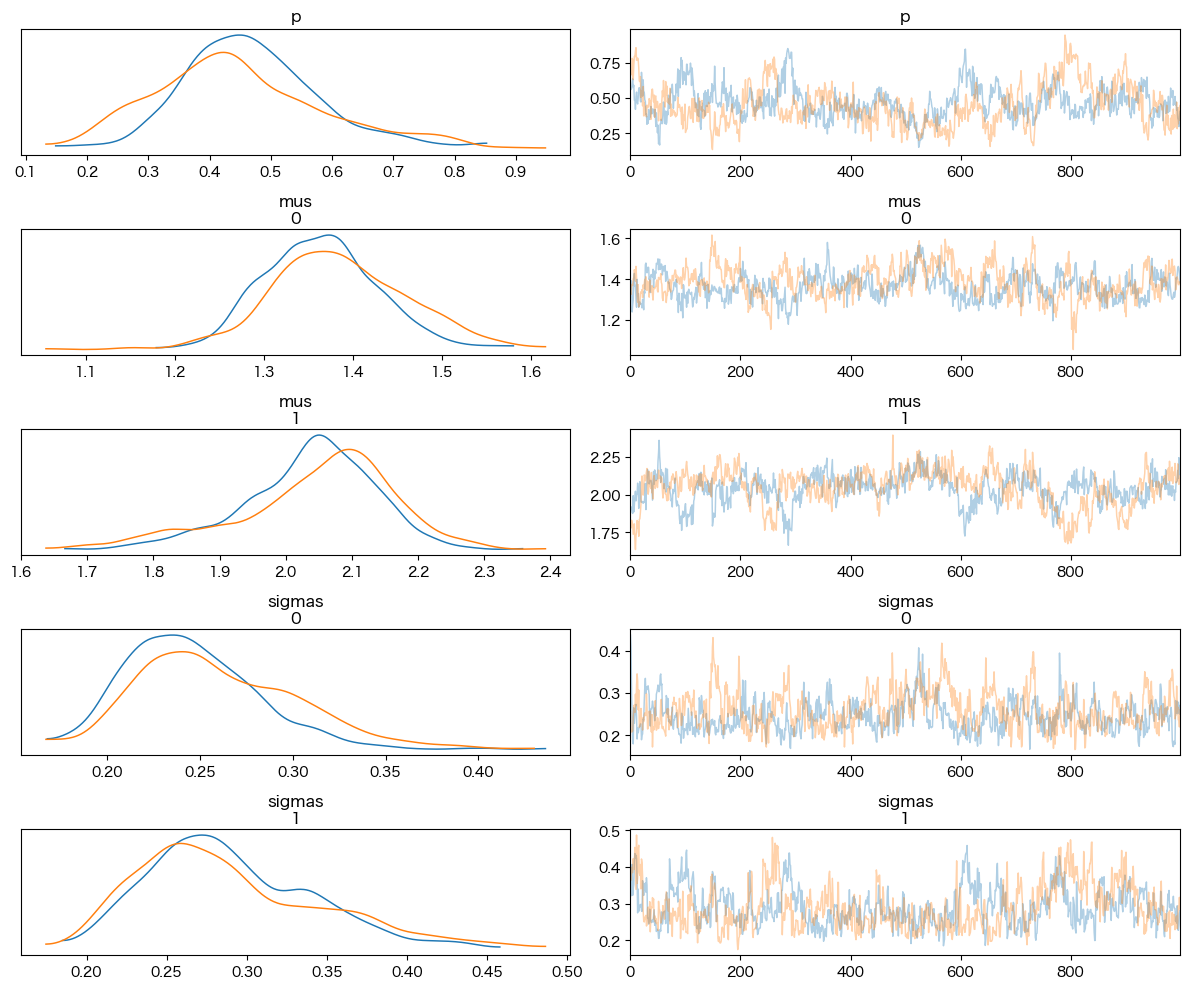

In [26]:
with model3:
    idata3 = pm.sample(random_seed=42, target_accept=0.999, chains=2)

az.plot_trace(idata3, var_names=["p", "mus", "sigmas"], compact=False)
plt.tight_layout()